In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
import os, sys
import pandas as pd
import sklearn
import sklearn.svm, sklearn.discriminant_analysis
import time
import scipy.stats
import copy
import statsmodels
from statsmodels.stats.anova import AnovaRM

root = '/usr/local/serenceslab/maggie/shapeDim/'
sys.path.append(os.path.join(root, 'Analysis'))
from code_utils import file_utils, data_utils, plot_utils, stats_utils, grid_utils

In [2]:
import bootstrap_confidence_binary
bootstrap_confidence_binary.bootstrap_binary_hardtrials(n_boot_iter = 1000)

0
1
2
3
4
5
6


In [2]:
import bootstrap_confidence_binary
bootstrap_confidence_binary.bootstrap_binary_hardtrials_include_checker(n_boot_iter = 1000, \
                                                                        correct_only=True)

0
1
2
3
4
5
6


In [2]:
task_names = ['Linear (1)','Linear (2)','Checker', 'Repeat'];
n_tasks = len(task_names)
task_colors = np.flipud(cm.GnBu(np.linspace(0,1,5))[1:,:])

n_subjects = 7
subjects = np.arange(1,8)
subcolors = cm.Dark2(np.linspace(0,1,n_subjects))

In [3]:
lab = dict()
for ss in subjects:
    
    # get labels for all the trials, this subject
    main_labels = data_utils.load_main_task_labels(ss)
    rep_labels = data_utils.load_repeat_task_labels(ss)
    lab[ss] = pd.concat([main_labels, rep_labels], axis=0)
    

In [4]:
save_folder = os.path.join(root, 'Analysis', 'decoding_results')
save_filename = os.path.join(save_folder, 'decode_binary_withintask.npy')
dec_withintask = np.load(save_filename, allow_pickle=True).item()
dec_withintask.keys()
roi_names = dec_withintask['roi_names']
n_rois = len(roi_names)

In [5]:
save_folder = os.path.join(root, 'Analysis', 'decoding_results')
fn2load = os.path.join(save_folder, 'decode_binary_hardtrials_include_checker_bootstrap_correctonly.npy')
b = np.load(fn2load, allow_pickle=True).item()
b.keys()
signedconf_hardtrials_boot = b['signedconf_hardtrials_boot']

Text(0.5, 0.98, 'Centermost trials, mean +/- SEM across subjects')

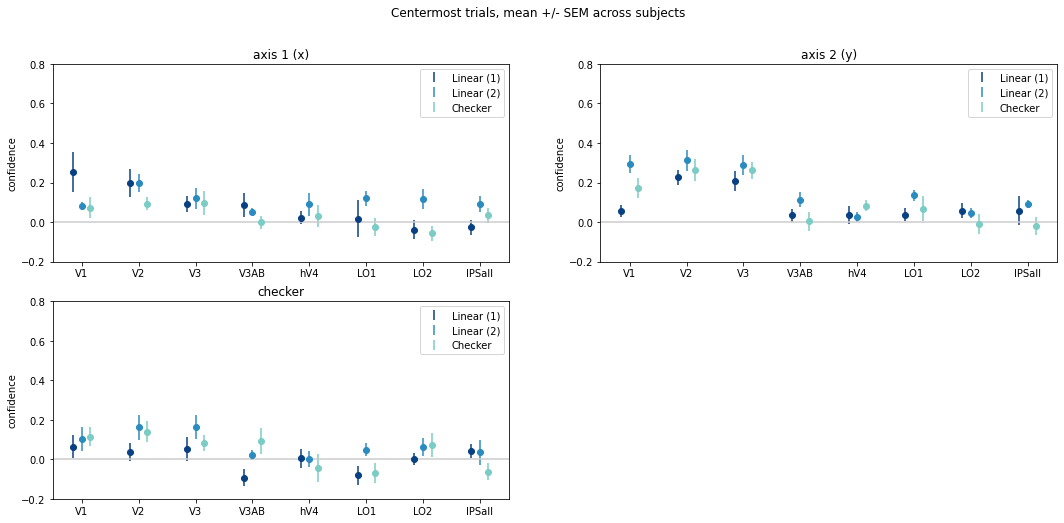

In [7]:
vals = np.mean(signedconf_hardtrials_boot, axis=4)
meanvals = np.mean(vals, axis=0)
semvals = np.std(vals, axis=0)/np.sqrt(n_subjects)

x_jitter = np.linspace(-0.15, 0.15, 3)

plt.figure(figsize=(18,8))


for ii, axis_name in enumerate(['axis 1 (x)','axis 2 (y)','checker']):

    plt.subplot(2,2,ii+1)
    
    
    plt.axhline(0, color=[0.8, 0.8, 0.8])
    
    lh = []
    
    # non_overlapping = (cilow[:,0,ii] > cihigh[:,1,ii]) | (cilow[:,1,ii] > cihigh[:,0,ii])

    for ti in [0,1,2]:
        
        x_ticks = np.arange(n_rois) + x_jitter[ti]
    
        plt.plot(x_ticks, meanvals[:,ti,ii], 'o',color=task_colors[ti])
        h = plt.errorbar(x_ticks, meanvals[:,ti,ii], \
                         semvals[:,ti,ii], \
                         xerr=None, color=task_colors[ti], linestyle='none')
        lh.append(h)
        
#     for ri in range(n_rois):
            
#         plt.plot(ri+x_jitter, meanvals[ri,:,ii],'-',color=[0.6, 0.6, 0.6])
        
#         plt.plot(ri+x_jitter, vals[:,ri,:,ii].T, color=[0.8, 0.8, 0.8], zorder=-10)
#         if non_overlapping[ri]:
#             yval = np.max(cihigh[ri,:,ii])+0.02
#             plt.annotate('*',[ri,yval])

    plt.ylim([-0.20, 0.80])
    
    plt.xticks(np.arange(n_rois), roi_names)
    plt.ylabel('confidence')
    
    plt.legend(lh,task_names)
    
    plt.title(axis_name)
    
plt.suptitle('Centermost trials, mean +/- SEM across subjects')


In [13]:
for ii, axis_name in enumerate(['axis 1 (x)','axis 2 (y)', 'checker']):

    vals = np.mean(signedconf_hardtrials_boot, axis=4)[:,:,:,ii]
    
    anova_result = stats_utils.rmanova_2way(vals, ['roi','task'], do_shuffle=False)

    anova_result['Pr > F'] = anova_result['Pr > F'].round(4)

    print('\nAnova for confidence w/r/t %s, hardest trials'%(axis_name))
    print(anova_result)



Anova for confidence w/r/t axis 1 (x), hardest trials
           F Value  Num DF  Den DF  Pr > F
roi       3.170192     7.0    42.0  0.0088
task      4.998950     2.0    12.0  0.0264
roi:task  1.055598    14.0    84.0  0.4090

Anova for confidence w/r/t axis 2 (y), hardest trials
            F Value  Num DF  Den DF  Pr > F
roi       17.317552     7.0    42.0  0.0000
task       3.759694     2.0    12.0  0.0540
roi:task   1.212361    14.0    84.0  0.2821

Anova for confidence w/r/t checker, hardest trials
           F Value  Num DF  Den DF  Pr > F
roi       5.767000     7.0    42.0  0.0001
task      1.079283     2.0    12.0  0.3707
roi:task  0.951726    14.0    84.0  0.5087


In [14]:
for ii, axis_name in enumerate(['axis 1 (x)','axis 2 (y)', 'checker']):

    vals = np.mean(signedconf_hardtrials_boot, axis=4)[:,:,[0,1],ii]
    
    anova_result = stats_utils.rmanova_2way(vals, ['roi','task'], do_shuffle=False)

    anova_result['Pr > F'] = anova_result['Pr > F'].round(4)

    print('\nAnova for confidence w/r/t %s, hardest trials'%(axis_name))
    print(anova_result)


Anova for confidence w/r/t axis 1 (x), hardest trials
           F Value  Num DF  Den DF  Pr > F
roi       1.958810     7.0    42.0  0.0840
task      1.516252     1.0     6.0  0.2643
roi:task  1.777439     7.0    42.0  0.1174

Anova for confidence w/r/t axis 2 (y), hardest trials
           F Value  Num DF  Den DF  Pr > F
roi       8.766289     7.0    42.0  0.0000
task      7.978193     1.0     6.0  0.0302
roi:task  2.311183     7.0    42.0  0.0435

Anova for confidence w/r/t checker, hardest trials
           F Value  Num DF  Den DF  Pr > F
roi       2.922533     7.0    42.0  0.0139
task      1.378374     1.0     6.0  0.2849
roi:task  0.936137     7.0    42.0  0.4893


In [15]:
for ii, axis_name in enumerate(['axis 1 (x)','axis 2 (y)', 'checker']):

    vals = np.mean(signedconf_hardtrials_boot, axis=4)[:,:,[0,2],ii]
    
    anova_result = stats_utils.rmanova_2way(vals, ['roi','task'], do_shuffle=False)

    anova_result['Pr > F'] = anova_result['Pr > F'].round(4)

    print('\nAnova for confidence w/r/t %s, hardest trials'%(axis_name))
    print(anova_result)


Anova for confidence w/r/t axis 1 (x), hardest trials
           F Value  Num DF  Den DF  Pr > F
roi       3.832652     7.0    42.0  0.0026
task      4.426372     1.0     6.0  0.0800
roi:task  0.678658     7.0    42.0  0.6890

Anova for confidence w/r/t axis 2 (y), hardest trials
            F Value  Num DF  Den DF  Pr > F
roi       11.001220     7.0    42.0  0.0000
task       0.326601     1.0     6.0  0.5884
roi:task   0.935761     7.0    42.0  0.4895

Anova for confidence w/r/t checker, hardest trials
           F Value  Num DF  Den DF  Pr > F
roi       4.802546     7.0    42.0  0.0005
task      2.716462     1.0     6.0  0.1504
roi:task  1.067184     7.0    42.0  0.4011


In [16]:
for ii, axis_name in enumerate(['axis 1 (x)','axis 2 (y)', 'checker']):

    vals = np.mean(signedconf_hardtrials_boot, axis=4)[:,:,[1,2],ii]
    
    anova_result = stats_utils.rmanova_2way(vals, ['roi','task'], do_shuffle=False)

    anova_result['Pr > F'] = anova_result['Pr > F'].round(4)

    print('\nAnova for confidence w/r/t %s, hardest trials'%(axis_name))
    print(anova_result)


Anova for confidence w/r/t axis 1 (x), hardest trials
           F Value  Num DF  Den DF  Pr > F
roi       1.441261     7.0    42.0  0.2148
task      9.255067     1.0     6.0  0.0227
roi:task  0.793745     7.0    42.0  0.5967

Anova for confidence w/r/t axis 2 (y), hardest trials
            F Value  Num DF  Den DF  Pr > F
roi       14.596810     7.0    42.0  0.0000
task       3.056329     1.0     6.0  0.1310
roi:task   0.815410     7.0    42.0  0.5798

Anova for confidence w/r/t checker, hardest trials
           F Value  Num DF  Den DF  Pr > F
roi       3.494459     7.0    42.0  0.0048
task      0.395267     1.0     6.0  0.5527
roi:task  0.795261     7.0    42.0  0.5955


In [17]:

axis_names = ['axis 1 (x)','axis 2 (y)', 'checker']
for ii in [0,1,2]:

    for ti_pair in [[0,1],[0,2],[1,2]]:

        vals = np.mean(signedconf_hardtrials_boot, axis=4)

        tstats = np.zeros((n_rois,),dtype=float)
        pvals = np.zeros((n_rois,),dtype=float)
        n_subs_samedir = np.zeros((n_rois,),dtype=int)

        rndseed = 2342344
        for rr in range(n_rois):

            vals1 = vals[:,rr,ti_pair[0],ii]
            vals2 = vals[:,rr,ti_pair[1],ii]

            p, t = stats_utils.paired_ttest_nonpar(vals1, vals2, \
                                                   n_iter=10000, rndseed=rndseed)    
            pvals[rr] = p
            tstats[rr] = t;

            # how many subjects go in same direction?
            subj_diffs = vals1-vals2
            n_subs_samedir[rr] = np.maximum(np.sum(subj_diffs>0), np.sum(subj_diffs<0))

        task_df = pd.DataFrame({'t-stat for task 1 > task 2': tstats, \
                                'pvalue': pvals, \
                                'n_subs_indiv': n_subs_samedir}, \
                                  index=roi_names)
        print('\nclassify %s'%(axis_names[ii]))
        print('%s task > %s task'%(task_names[ti_pair[0]], task_names[ti_pair[1]]))

        print(task_df.round(3))


classify axis 1 (x)
Linear (1) task > Linear (2) task
        t-stat for task 1 > task 2  pvalue  n_subs_indiv
V1                           1.827   0.176             5
V2                          -0.015   1.003             4
V3                          -0.660   0.524             4
V3AB                         0.458   0.739             4
hV4                         -1.039   0.364             4
LO1                         -0.941   0.457             4
LO2                         -2.187   0.079             6
IPSall                      -2.722   0.062             6

classify axis 1 (x)
Linear (1) task > Checker task
        t-stat for task 1 > task 2  pvalue  n_subs_indiv
V1                           1.262   0.330             5
V2                           1.227   0.354             4
V3                          -0.068   0.990             4
V3AB                         1.541   0.205             5
hV4                         -0.087   0.880             5
LO1                          0.361   0